In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [234]:
def CalculateFontsize(xlim, ylim, ax, fig, rows, cols, unit_scale=1):
    # Get axis limits
    axXlim = ax.get_xlim()
    axYlim = ax.get_ylim()

    # Get figure dimensions in pixels
    fig_width, fig_height = fig.get_size_inches() * fig.dpi

    # Get axis dimensions in pixels
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width * fig.dpi, bbox.height * fig.dpi

    # Calculate font size proportional to axis units
    fontsize_x = unit_scale * ax_width / (axXlim[1] - axXlim[0]) / cols * (xlim[1] - xlim[0])
    fontsize_y = unit_scale * ax_height / (axYlim[1] - axYlim[0]) / rows * (ylim[1] - ylim[0])

    # Use the minimum of the two to keep the font size consistent
    fontsize = min(fontsize_x, fontsize_y)

    return fontsize

In [251]:
def DrawMSA(msa, seq_names = None, start = None, end = None,
            axlim = None, color_order = None, palette=None, ax=None, fig=None):
    # Get the canvas attributes.
    ax = ax or plt.gca()
    
    fig = fig or ax.get_figure()
    renderer = fig.canvas.get_renderer()
    
    height = len(msa)
    length = len(msa[0])
    
    # start, end: draw the [start,end] (both inclusive) region of the MSA
    if (start == None):
        start = 0
    elif (start < 0):
        start = length + start 
    if (end == None):
        end = length - 1 
    elif (end < 0):
        end = length + end 
    
    if (axlim == None):
        # Strange, why cols should be length, not end-start+1?
        fontsize = CalculateFontsize(ax.get_xlim(), ax.get_ylim(), ax, fig, height, length)
    else:
        fontsize = CalculateFontsize(axlim[0], axlim[1], ax, fig, height, length)
    chrColor = {}
    
    if color_order == None:
        for a in msa:
            for c in a[start:end+1]:
                if c not in chrColor:
                    size = len(chrColor)
                    chrColor[c] = sns.color_palette(palette)[size]
    else:
        for i,c in enumerate(color_order):
            chrColor[c] = sns.color_palette(palette)[i]
    
    lengthUnit = 1 / (end - start + 1)
    heightUnit = 1 / height 
    if (axlim != None):
        lengthUnit = (axlim[0][1] - axlim[0][0]) / (end - start + 1)
        heightUnit = (axlim[1][1] - axlim[1][0]) / height
    
    for i, a in enumerate(msa):
        for j,c in enumerate(a[start:end+1]):
            ax.text(x=(j + 0.5)*lengthUnit, y=i * heightUnit, s=c, color="black",
                va="bottom", ha="center", fontsize=fontsize,
                transform=ax.transAxes if axlim == None else ax.transData)
            ax.add_patch( patches.Rectangle(xy=(j * lengthUnit, i * heightUnit),
                                           width = lengthUnit, height=heightUnit,
                                          facecolor=chrColor[c], linewidth=fontsize/50, edgecolor="white",
                                          transform=ax.transAxes if axlim == None else ax.transData))
    if (axlim == None):
        ax.set_xlim(-0.5, end - start + 1 - 0.5)
        ax.set_ylim(-0.5, height - 0.5)
        
        ticks = []
        tickLabels = []
        for i in range(start, end + 1):
            ticks.append(i - start)
            tickLabels.append(i)
        ax.set_xticks(ticks, tickLabels)
        
        ticks = []
        tickLabels = []
        for i in range(height):
            ticks.append(i)
            tickLabels.append(i if seq_names == None else seq_names[i])
        ax.set_yticks(ticks, tickLabels)
            
    return ax

In [ ]:
def DrawMSAConsensus(msa, start = None, end = None):
    return

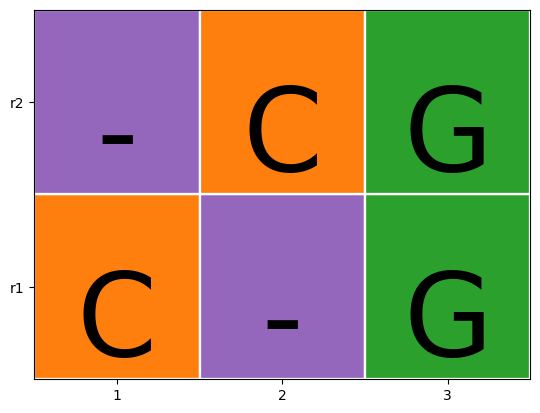

In [247]:
ax=DrawMSA(msa=["AC-G-T", "A-CGT-"], seq_names = ["r1", "r2"],
           start = 1, end = 3, color_order="ACGT-")

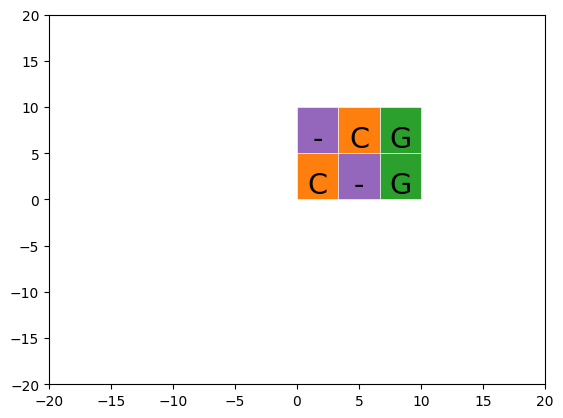

In [252]:
ax = plt.gca()
ax.set(xlim=[-20,20], ylim=[-20, 20])
ax=DrawMSA(msa=["AC-G-T", "A-CGT-"], color_order="ACGT-",
          axlim=[[0,10], [0,10]], start=1, end=3, ax=ax)